## MOC3D Problem 1

This problem corresponds to the first problem presented in the MOC3D
report Konikow 1996, involving the transport of a dissolved constituent
in a steady, one-dimensional flow field. An analytical solution for this
problem is given by \cite{wexler1992}.  This example is simulated with the GWT Model in \mf, which receives flow information from a separate simulation with the GWF Model in \mf.  Results from the GWT Model are compared with the results from the \cite{wexler1992} analytical solution.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-moc3dp1"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Scenario-specific parameters - make sure there is at least one blank line before next item
parameters = {
    "ex-gwt-moc3d-p01a": {
        "longitudinal_dispersivity": 0.1,
        "retardation_factor": 1.0,
        "decay_rate": 0.0,
    },
    "ex-gwt-moc3d-p01b": {
        "longitudinal_dispersivity": 1.0,
        "retardation_factor": 1.0,
        "decay_rate": 0.0,
    },
    "ex-gwt-moc3d-p01c": {
        "longitudinal_dispersivity": 1.0,
        "retardation_factor": 2.0,
        "decay_rate": 0.0,
    },
    "ex-gwt-moc3d-p01d": {
        "longitudinal_dispersivity": 1.0,
        "retardation_factor": 1.0,
        "decay_rate": 0.01,
    },
}

# Scenario parameter units - make sure there is at least one blank line before next item
# add parameter_units to add units to the scenario parameter table
parameter_units = {
    "longitudinal_dispersivity": "$cm$",
    "retardation_factor": "unitless",
    "decay_rate": "$s^{-1}$",
}

# Model units
length_units = "centimeters"
time_units = "seconds"

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 122  # Number of columns
system_length = 12.0  # Length of system ($cm$)
delr = 0.1  # Column width ($cm$)
delc = 0.1  # Row width ($cm$)
top = 1.0  # Top of the model ($cm$)
botm = 0  # Layer bottom elevation ($cm$)
specific_discharge = 0.1  # Specific discharge ($cm s^{-1}$)
hydraulic_conductivity = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
porosity = 0.1  # Porosity of mobile domain (unitless)
total_time = 120.0  # Simulation time ($s$)
source_concentration = 1.0  # Source concentration (unitless)
initial_concentration = 0.0  # Initial concentration (unitless)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
class Wexler1d:
    """
    Analytical solution for 1D transport with inflow at a concentration of 1.
    at x=0 and a third-type bound at location l.
    Wexler Page 17 and Van Genuchten and Alves pages 66-67
    """

    def betaeqn(self, beta, d, v, l):
        return beta / np.tan(beta) - beta**2 * d / v / l + v * l / 4.0 / d

    def fprimebetaeqn(self, beta, d, v, l):
        """
        f1 = cotx - x/sinx2 - (2.0D0*C*x)

        """
        c = v * l / 4.0 / d
        return 1.0 / np.tan(beta) - beta / np.sin(beta) ** 2 - 2.0 * c * beta

    def fprime2betaeqn(self, beta, d, v, l):
        """
        f2 = -1.0D0/sinx2 - (sinx2-x*DSIN(x*2.0D0))/(sinx2*sinx2) - 2.0D0*C

        """
        c = v * l / 4.0 / d
        sinx2 = np.sin(beta) ** 2
        return (
            -1.0 / sinx2
            - (sinx2 - beta * np.sin(beta * 2.0)) / (sinx2 * sinx2)
            - 2.0 * c
        )

    def solvebetaeqn(self, beta, d, v, l, xtol=1.0e-12):
        from scipy.optimize import fsolve

        t = fsolve(
            self.betaeqn,
            beta,
            args=(d, v, l),
            fprime=self.fprime2betaeqn,
            xtol=xtol,
            full_output=True,
        )
        result = t[0][0]
        infod = t[1]
        isoln = t[2]
        msg = t[3]
        if abs(result - beta) > np.pi:
            raise Exception("Error in beta solution")
        err = self.betaeqn(result, d, v, l)
        fvec = infod["fvec"][0]
        if isoln != 1:
            print("Error in beta solve", err, result, d, v, l, msg)
        return result

    def root3(self, d, v, l, nval=1000):
        b = 0.5 * np.pi
        betalist = []
        for i in range(nval):
            b = self.solvebetaeqn(b, d, v, l)
            err = self.betaeqn(b, d, v, l)
            betalist.append(b)
            b += np.pi
        return betalist

    def analytical(self, x, t, v, l, d, tol=1.0e-20, nval=5000):
        sigma = 0.0
        betalist = self.root3(d, v, l, nval=nval)
        concold = None
        for i, bi in enumerate(betalist):
            denom = bi**2 + (v * l / 2.0 / d) ** 2 + v * l / d
            x1 = (
                bi
                * (bi * np.cos(bi * x / l) + v * l / 2.0 / d * np.sin(bi * x / l))
                / denom
            )

            denom = bi**2 + (v * l / 2.0 / d) ** 2
            x2 = np.exp(-1 * bi**2 * d * t / l**2) / denom

            sigma += x1 * x2
            term1 = 2.0 * v * l / d * np.exp(v * x / 2.0 / d - v**2 * t / 4.0 / d)
            conc = 1.0 - term1 * sigma
            if i > 0:
                assert concold is not None
                diff = abs(conc - concold)
                if np.all(diff < tol):
                    break
            concold = conc
        return conc

    def analytical2(self, x, t, v, l, d, e=0.0, tol=1.0e-20, nval=5000):
        """
        Calculate the analytical solution for one-dimension advection and
        dispersion using the solution of Lapidus and Amundson (1952) and
        Ogata and Banks (1961)

        Parameters
        ----------
        x : float or ndarray
            x position
        t : float or ndarray
            time
        v : float or ndarray
            velocity
        l : float
            length domain
        d : float
            dispersion coefficient
        e : float
            decay rate

        Returns
        -------
        result : float or ndarray
            normalized concentration value

        """
        u = v**2 + 4.0 * e * d
        u = np.sqrt(u)
        sigma = 0.0
        denom = (u + v) / 2.0 / v - (u - v) ** 2.0 / 2.0 / v / (u + v) * np.exp(
            -u * l / d
        )
        term1 = np.exp((v - u) * x / 2.0 / d) + (u - v) / (u + v) * np.exp(
            (v + u) * x / 2.0 / d - u * l / d
        )
        term1 = term1 / denom
        term2 = 2.0 * v * l / d * np.exp(v * x / 2.0 / d - v**2 * t / 4.0 / d - e * t)
        betalist = self.root3(d, v, l, nval=nval)
        concold = None
        for i, bi in enumerate(betalist):
            denom = bi**2 + (v * l / 2.0 / d) ** 2 + v * l / d
            x1 = (
                bi
                * (bi * np.cos(bi * x / l) + v * l / 2.0 / d * np.sin(bi * x / l))
                / denom
            )

            denom = bi**2 + (v * l / 2.0 / d) ** 2 + e * l**2 / d
            x2 = np.exp(-1 * bi**2 * d * t / l**2) / denom

            sigma += x1 * x2

            conc = term1 - term2 * sigma
            if i > 0:
                assert concold is not None
                diff = abs(conc - concold)
                if np.all(diff < tol):
                    break
            concold = conc
        return conc


def get_sorption_dict(retardation_factor):
    sorption = None
    bulk_density = None
    distcoef = None
    if retardation_factor > 1.0:
        sorption = "linear"
        bulk_density = 1.0
        distcoef = (retardation_factor - 1.0) * porosity / bulk_density
    sorption_dict = {
        "sorption": sorption,
        "bulk_density": bulk_density,
        "distcoef": distcoef,
    }
    return sorption_dict


def get_decay_dict(decay_rate, sorption=False):
    first_order_decay = None
    decay = None
    decay_sorbed = None
    if decay_rate != 0.0:
        first_order_decay = True
        decay = decay_rate
        if sorption:
            decay_sorbed = decay_rate
    decay_dict = {
        "first_order_decay": first_order_decay,
        "decay": decay,
        "decay_sorbed": decay_sorbed,
    }
    return decay_dict


def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((total_time, 1, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [
            [(0, 0, 0), specific_discharge * delc * delr * top, source_concentration],
        ],
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=["CONCENTRATION"],
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(sim_folder, longitudinal_dispersivity, retardation_factor, decay_rate):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((total_time, 240, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        **get_sorption_dict(retardation_factor),
        **get_decay_dict(decay_rate, retardation_factor > 1.0),
    )
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=longitudinal_dispersivity,
        ath1=longitudinal_dispersivity,
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    # flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=[((0, 0, 0), source_concentration),])
    obs_data = {
        f"{name}.obs.csv": [
            ("X005", "CONCENTRATION", (0, 0, 0)),
            ("X405", "CONCENTRATION", (0, 0, 40)),
            ("X1105", "CONCENTRATION", (0, 0, 110)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def build_models(sim_name, longitudinal_dispersivity, retardation_factor, decay_rate):
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(
        sim_name, longitudinal_dispersivity, retardation_factor, decay_rate
    )
    return sim_mf6gwf, sim_mf6gwt


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent)
    assert success, buff
    success, buff = sim_mf6gwt.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 3)


def plot_results_ct(
    sims, idx, longitudinal_dispersivity, retardation_factor, decay_rate
):
    _, sim_mf6gwt = sims
    with styles.USGSPlot():
        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        alabel = ["ANALYTICAL", "", ""]
        mlabel = ["MODFLOW 6", "", ""]
        iskip = 5
        atimes = np.arange(0, total_time, 0.1)
        obsnames = ["X005", "X405", "X1105"]
        simtimes = mf6gwt_ra["totim"]
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )
        for i, x in enumerate([0.05, 4.05, 11.05]):
            a1 = Wexler1d().analytical2(
                x,
                atimes,
                specific_discharge / retardation_factor,
                system_length,
                dispersion_coefficient,
                decay_rate,
            )
            if idx == 0:
                idx_filter = a1 < 0
                a1[idx_filter] = 0
                idx_filter = a1 > 1
                a1[idx_filter] = 0
                idx_filter = atimes > 0
                if i == 2:
                    idx_filter = atimes > 79
            elif idx > 0:
                idx_filter = atimes > 0
            axs.plot(atimes[idx_filter], a1[idx_filter], color="k", label=alabel[i])
            axs.plot(
                simtimes[::iskip],
                mf6gwt_ra[obsnames[i]][::iskip],
                marker="o",
                ls="none",
                mec="blue",
                mfc="none",
                markersize="4",
                label=mlabel[i],
            )
        axs.set_ylim(0, 1.2)
        axs.set_xlim(0, 120)
        axs.set_xlabel("Time (seconds)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        if idx in [0, 1]:
            axs.text(1, 0.5, "x=0.05")
            axs.text(45, 0.5, "x=4.05")
            axs.text(100, 0.5, "x=11.05")
        axs.legend()

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-ct.png"
            fpth = figs_path / fname
            fig.savefig(fpth)


def plot_results_cd(
    sims, idx, longitudinal_dispersivity, retardation_factor, decay_rate
):
    _, sim_mf6gwt = sims
    with styles.USGSPlot():
        ucnobj_mf6 = sim_mf6gwt.trans.output.concentration()

        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        alabel = ["ANALYTICAL", "", ""]
        mlabel = ["MODFLOW 6", "", ""]
        iskip = 5
        ctimes = [6.0, 60.0, 120.0]
        x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol - 1)
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )

        for i, t in enumerate(ctimes):
            a1 = Wexler1d().analytical2(
                x,
                t,
                specific_discharge / retardation_factor,
                system_length,
                dispersion_coefficient,
                decay_rate,
            )
            if idx == 0:
                idx_filter = x > system_length
                if i == 0:
                    idx_filter = x > 6
                if i == 1:
                    idx_filter = x > 9
                a1[idx_filter] = 0.0
            axs.plot(x, a1, color="k", label=alabel[i])
            simconc = ucnobj_mf6.get_data(totim=t).flatten()
            axs.plot(
                x[::iskip],
                simconc[::iskip],
                marker="o",
                ls="none",
                mec="blue",
                mfc="none",
                markersize="4",
                label=mlabel[i],
            )
        axs.set_ylim(0, 1.1)
        axs.set_xlim(0, 12)
        if idx in [0, 1]:
            axs.text(0.5, 0.7, "t=6 s")
            axs.text(5.5, 0.7, "t=60 s")
            axs.text(11, 0.7, "t=120 s")
        axs.set_xlabel("Distance (cm)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        plt.legend()

        if plot_show:
            plt.show()
        if plot_save:
            sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-cd.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    sims = build_models(key, **parameter_dict)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)
    if plot:
        plot_results_ct(sims, idx, **parameter_dict)
        plot_results_cd(sims, idx, **parameter_dict)

Building mf6gwf model...ex-gwt-moc3d-p01a
Building mf6gwt model...ex-gwt-moc3d-p01a


run_models took 72.44 ms


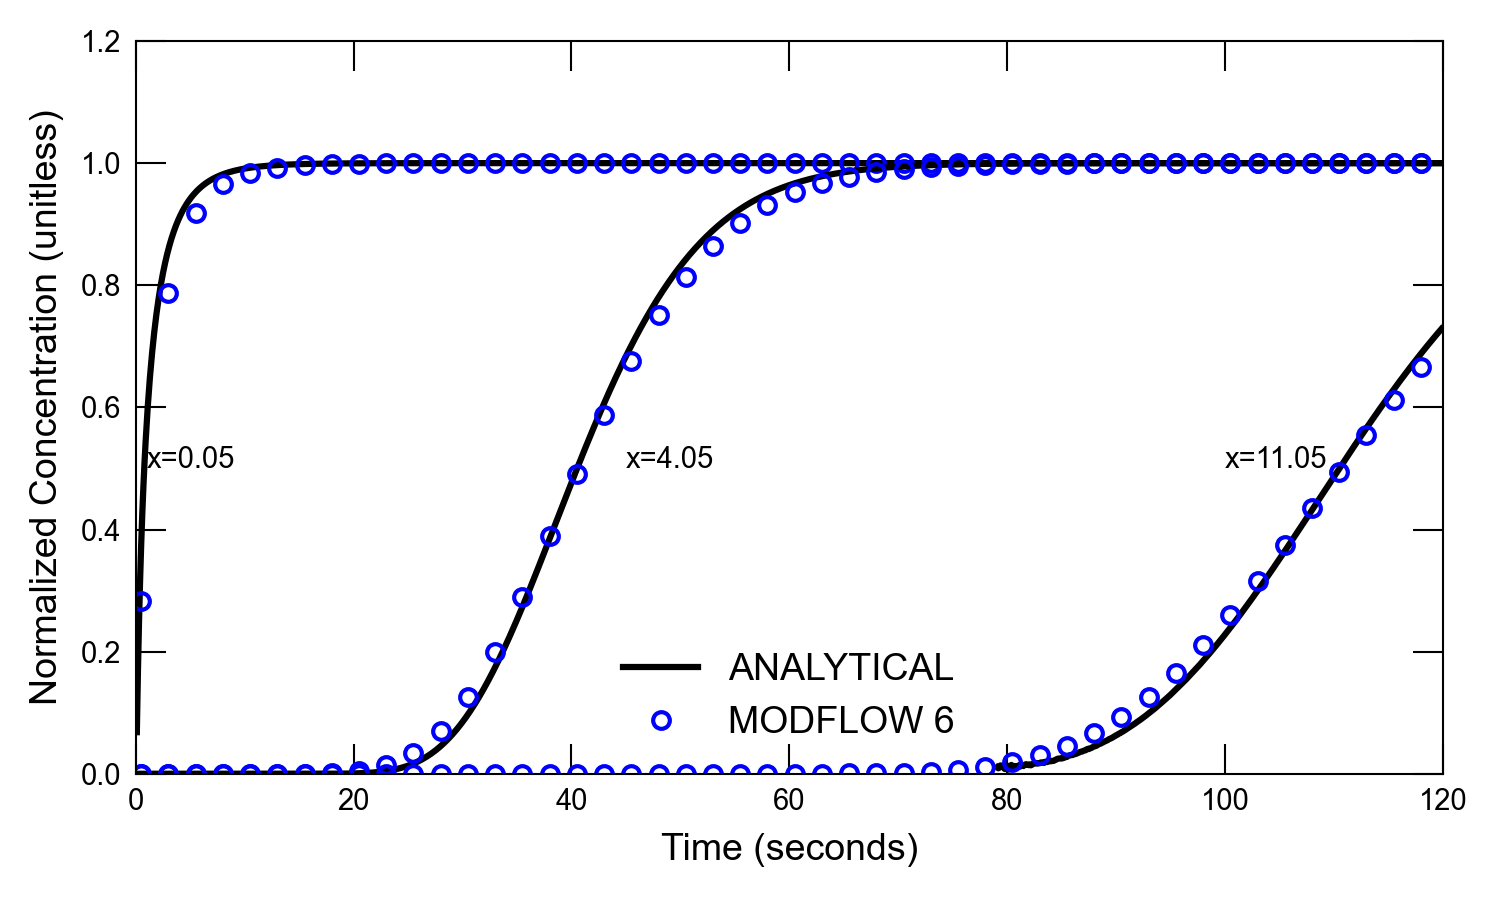

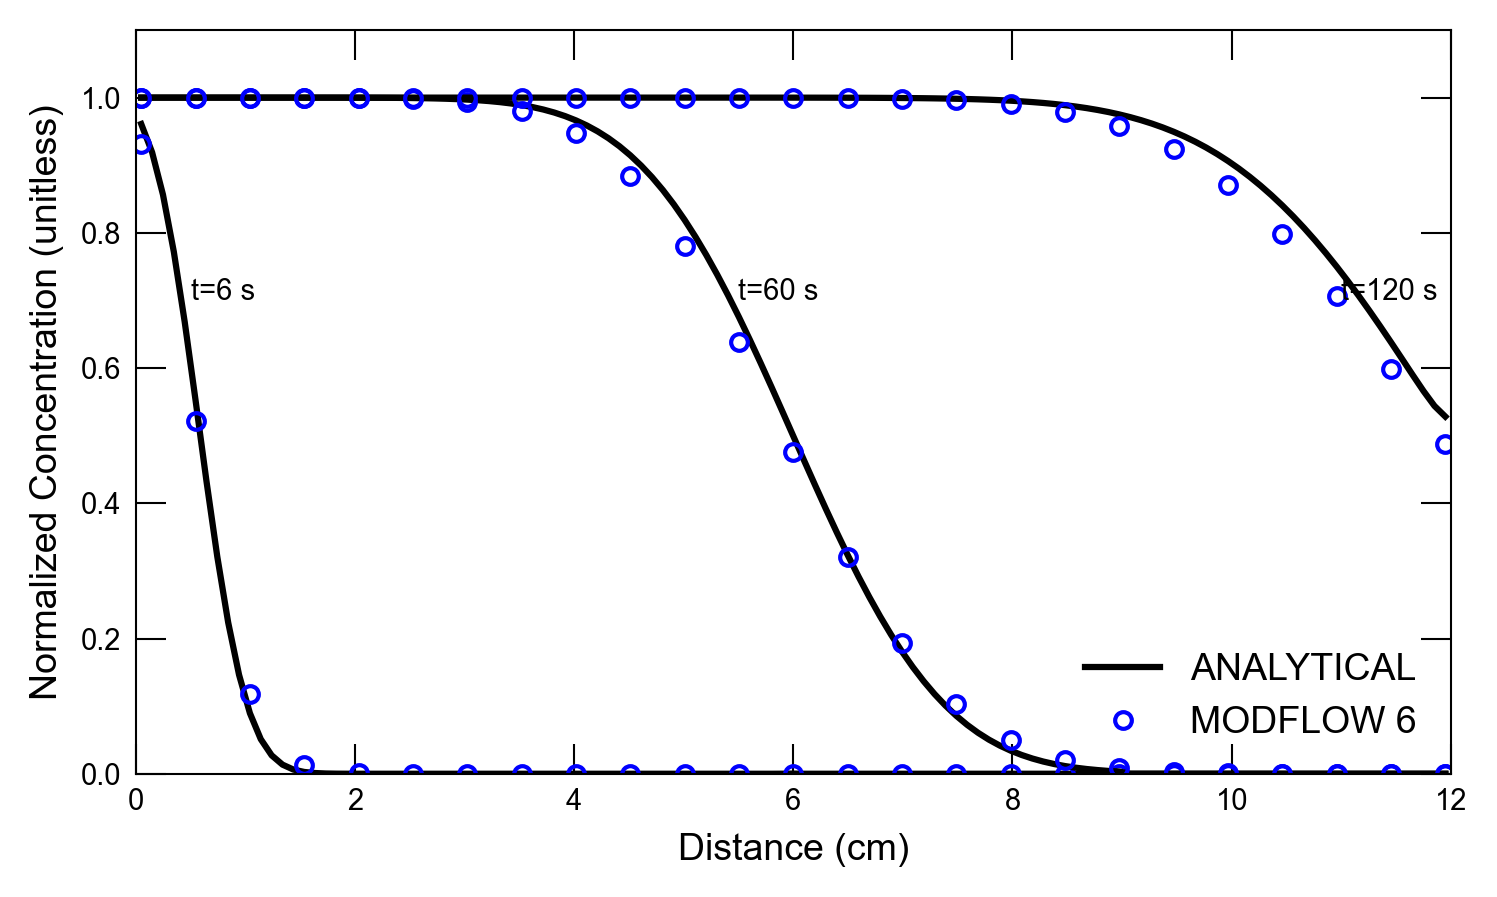

In [6]:
scenario(0)

Building mf6gwf model...ex-gwt-moc3d-p01b
Building mf6gwt model...ex-gwt-moc3d-p01b
run_models took 73.24 ms


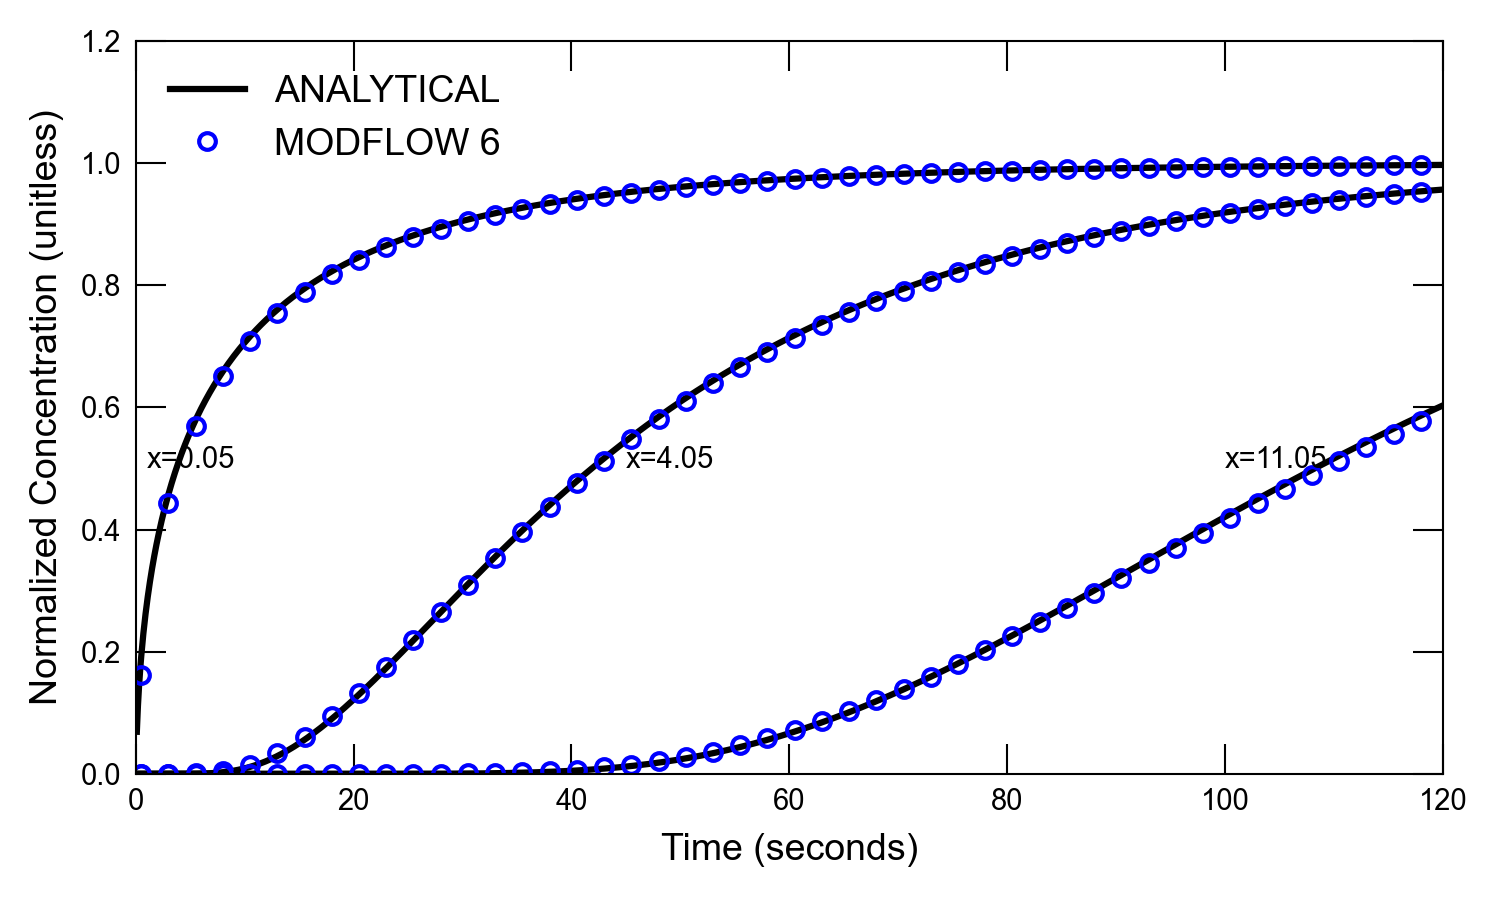

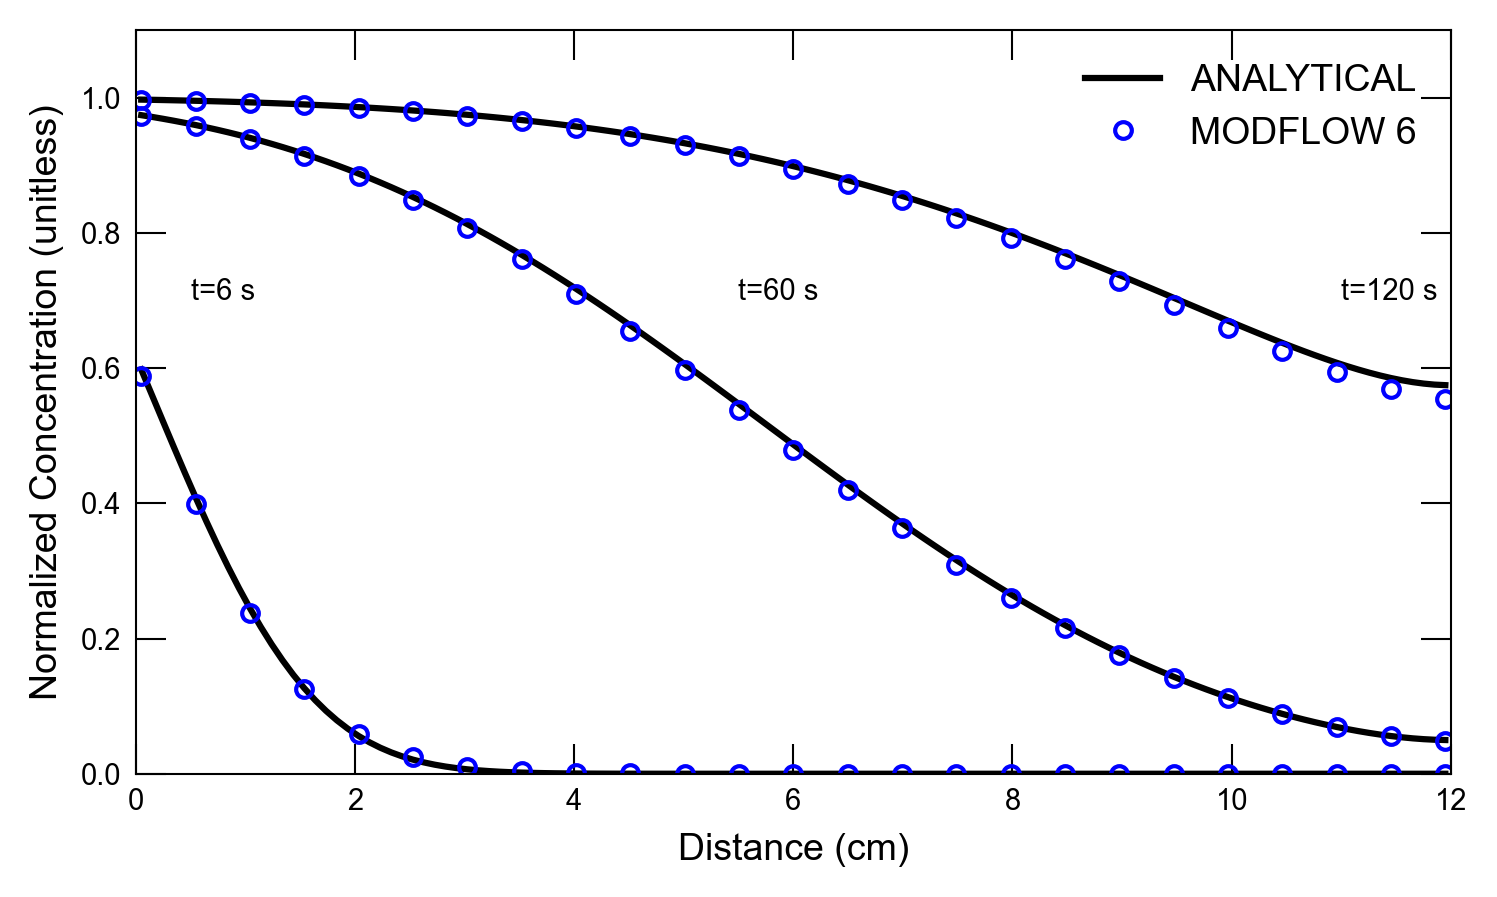

In [7]:
scenario(1)

Building mf6gwf model...ex-gwt-moc3d-p01c
Building mf6gwt model...ex-gwt-moc3d-p01c


run_models took 76.69 ms


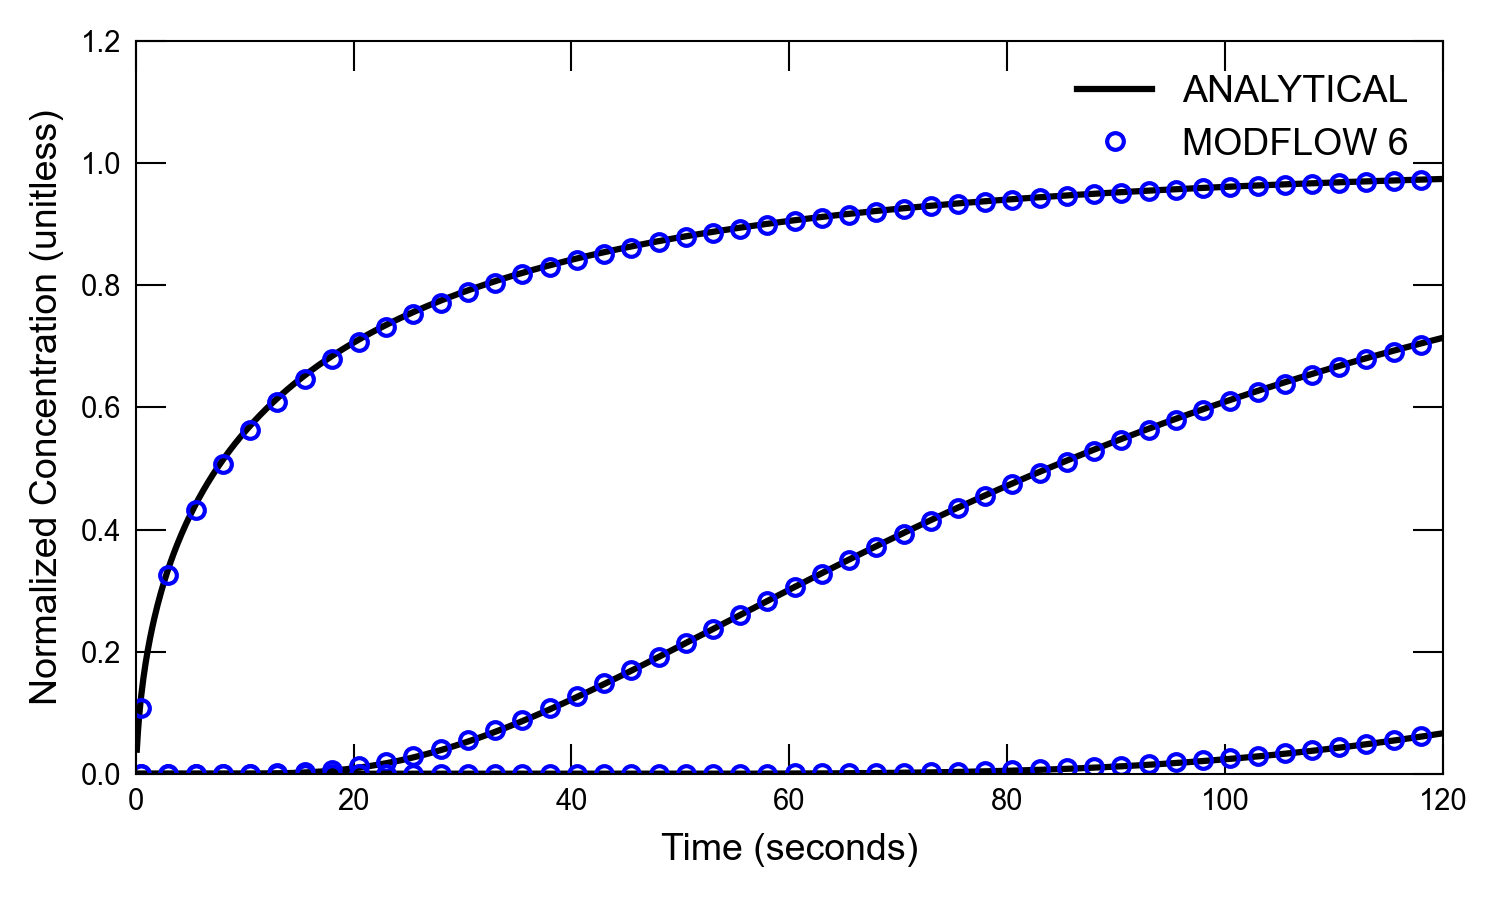

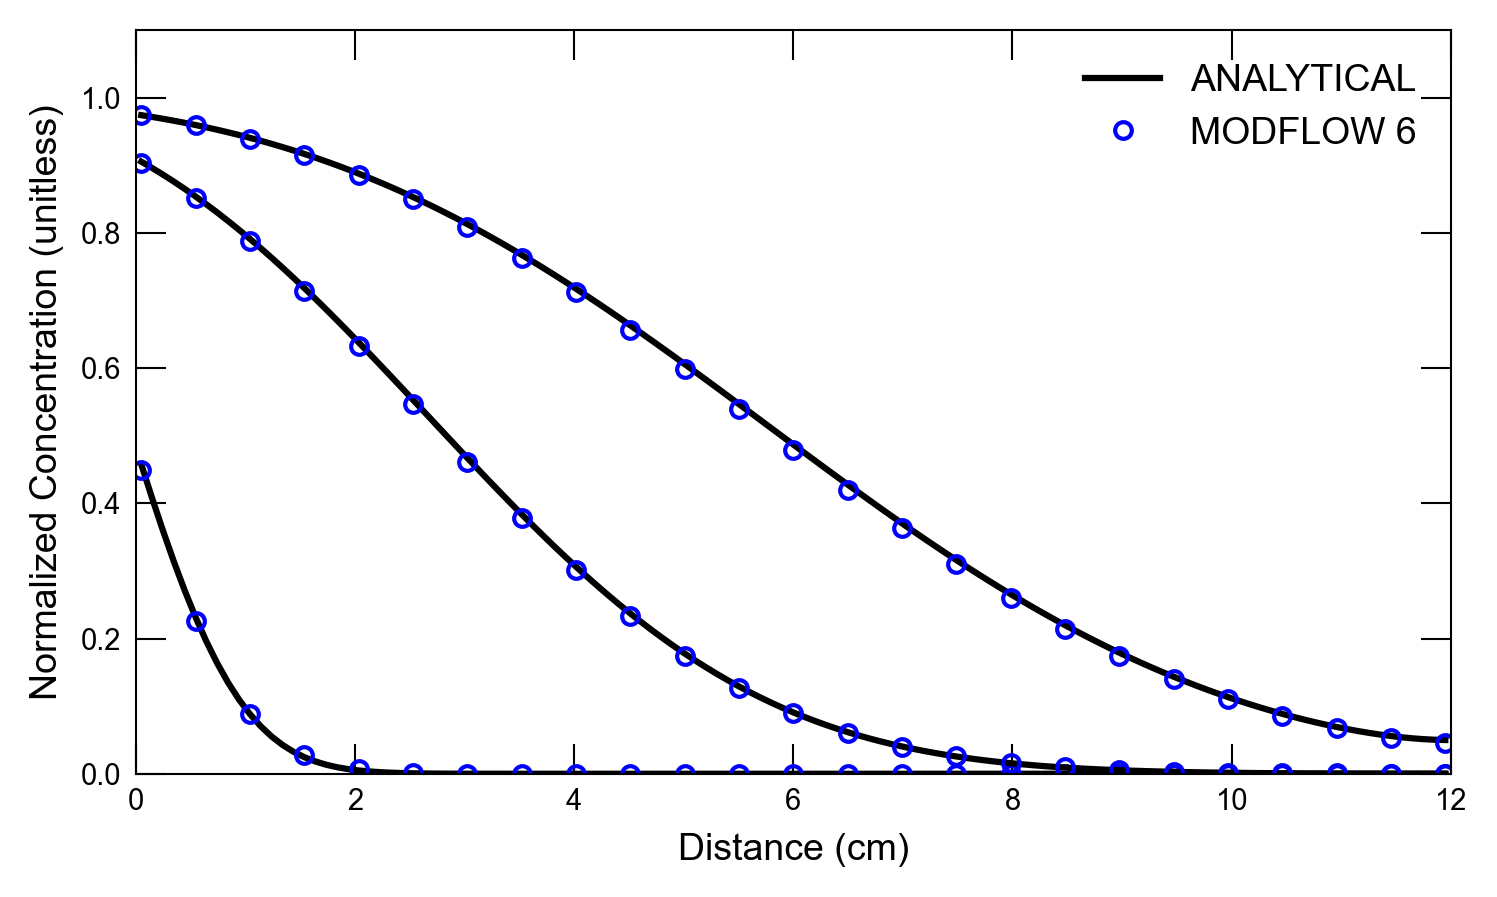

In [8]:
scenario(2)

Building mf6gwf model...ex-gwt-moc3d-p01d
Building mf6gwt model...ex-gwt-moc3d-p01d
run_models took 71.67 ms


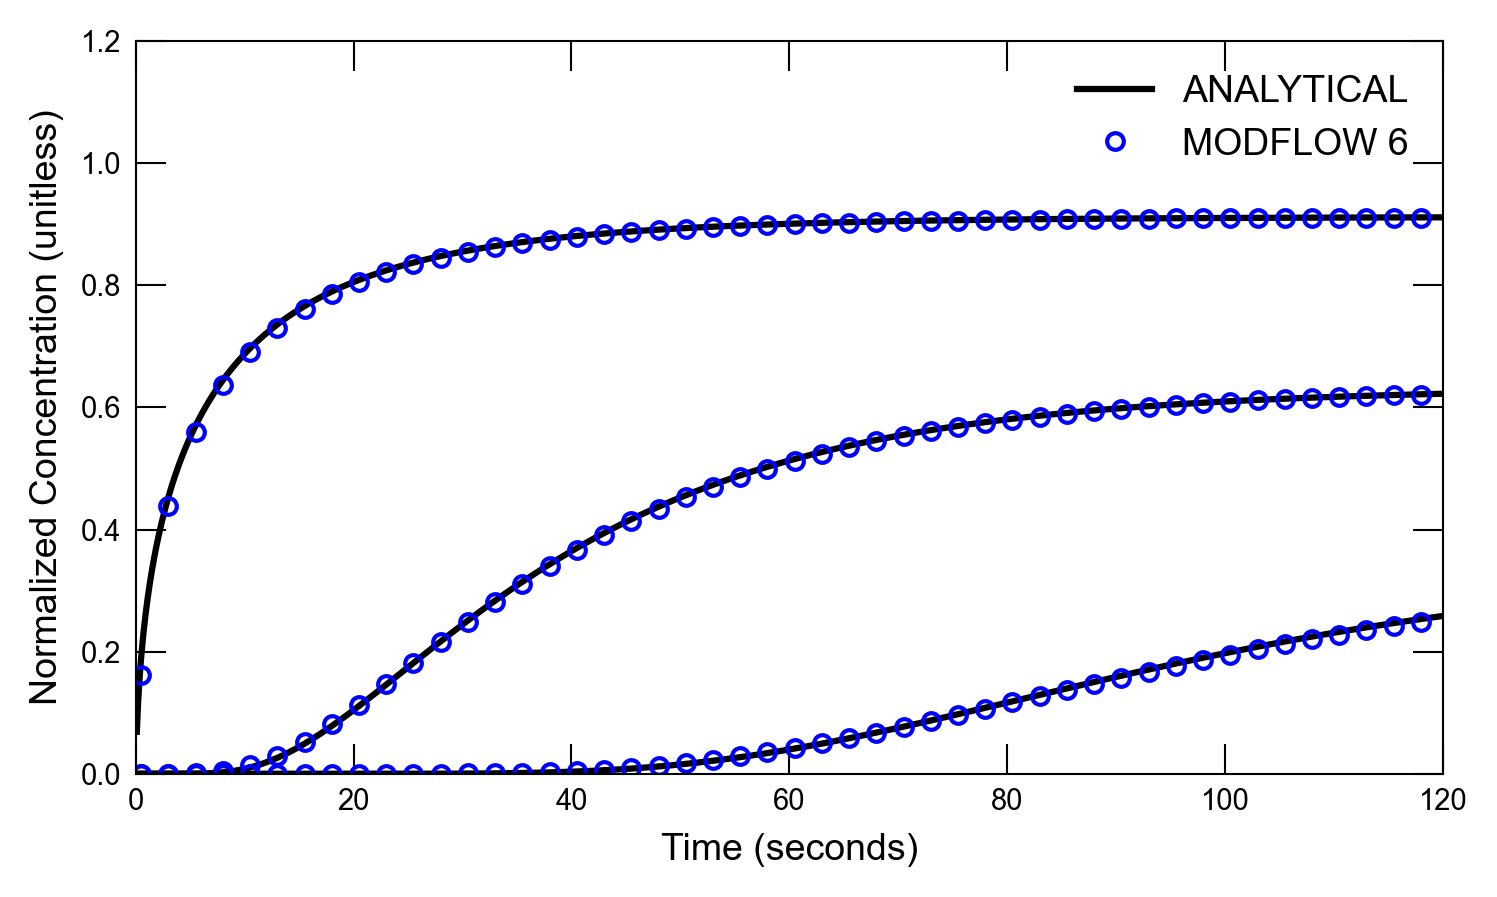

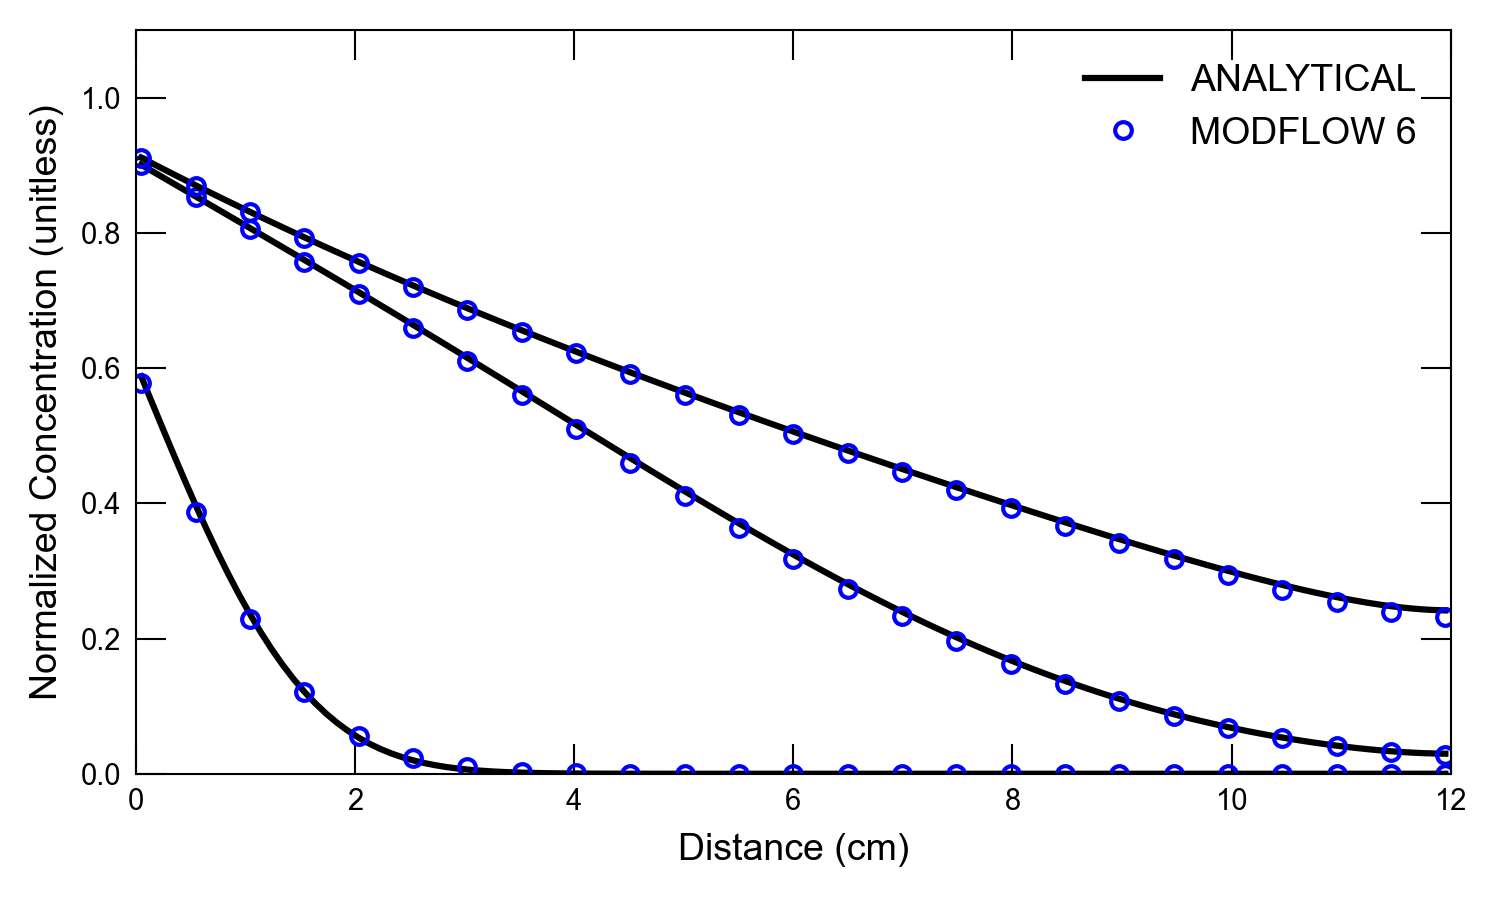

In [9]:
scenario(3)